# Reinforcement-learning-based Learning Rate Scheduler (RLR Scheduler)

## Постановка задачи

###Данные для обработки

Мы генерируем набор функций вида

$$
y(x)=w_0 + w_1 x + w_2 x^2 + w_3 x^3 + w_4 x^4,
$$

где коэффициенты $w_i$ различаются для каждой функции и убывают по масштабу с ростом степени, что имитирует разложение Маклорена. Для каждой функции задано $20$ точек $x\in[-2,2]$. Вход модели — вектор значений $y(x)$ в этих $20$ точках, выход — предсказанные коэффициенты:
$$
\hat w = (\hat w_0,\dots,\hat w_4).
$$


###Обучаемая модель

Сеть-аппроксиматор `MaclaurinNet` представляет собой небольшую полносвязную нейросеть и обучается минимизацией среднеквадратичной ошибки:

$$
L = \mathrm{MSE}(w,\hat w).
$$

## Решение. DQN-планировщик Learning Rate для алгоритмов оптимизации на примере Adam

Планировщик `RLR` формулируется как задача обучения агента `DQN`, который **адаптивно выбирает значение learning rate оптимизатора `Adam`** при обучении модели `MaclaurinNet`. Параметры сети обновляются стандартным алгоритмом `Adam`, а агент управляет только величиной `learning rate`, изменяя её перед каждым шагом оптимизации.

### Состояние среды

Состояние среды имеет низкую размерность и отражает текущую динамику обучения:

$$s_t = \bigl(L_t, L_t - L_{t-1}\bigr),$$

где $L_t$ — текущее значение функции потерь, вычисленное на всём датасете, а $L_t - L_{t-1}$ — разность потерь между текущим и предыдущим шагами оптимизации.

### Пространство действий

Пространство действий дискретно и задаётся **относительными изменениями learning rate**. Агент выбирает одно из трёх действий: уменьшить `lr`, оставить без изменений, увеличить. Текущее значение `lr` кодируется индексом на заранее заданной логарифмической сетке:

$$\{\eta_1,\eta_2,\dots,\eta_M\},$$

охватывающей несколько порядков величины. Выбранное действие сдвигает индекс на $\{-1,0,+1\}$ с последующей проекцией на допустимый диапазон.

### Функция награды

Награда определяется уменьшением функции потерь за один шаг оптимизации:

$$r_t = L_t - L_{t+1}.$$

Такая награда напрямую поощряет выбор значений `learning rate`, приводящих к максимальному снижению ошибки за один шаг.

### Обучение агента

Агент `RLR` обучается по классическому алгоритму `DQN` с использованием replay buffer, таргетной Q-сети, $\epsilon$-жадной стратегии выбора действий, функции потерь `Huber`. Таргетная сеть обновляется мягким образом, что повышает устойчивость обучения.

### Данные

Датасет состоит из $256$ различных полиномиальных функций степени $4$. Для каждого примера входом является вектор значений $y(x)$ в $20$ точках $x \in [-2,2]$, а целевой переменной — вектор коэффициентов:

$$w = (w_0, w_1, w_2, w_3, w_4).$$


## Baseline решения без использования DQN

### Генерация данных

Здесь мы формируем набор из $256$ функций степени $4$, для каждой функции берём $20$ точек $x\in[-2,2]$. Коэффициенты $w_i$ генерируем нормально, но затем масштабирем так, чтобы старшие степени имели меньше вклад. Результат — `dataset_inputs` размером $(256,20)$ и `dataset_coeffs` размером $(256,5)$.

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_SAMPLES = 256
x = torch.linspace(-2.0, 2.0, 20, device=device)
degrees = 5
scale = torch.tensor([1.0, 0.5, 0.2, 0.1, 0.05], device=device)
ws = torch.randn(N_SAMPLES, degrees, device=device) * scale.unsqueeze(0)
x_powers = torch.stack([x**i for i in range(degrees)], dim=0)
ys = ws @ x_powers
dataset_inputs = ys
dataset_coeffs = ws

### Архитектура `MaclaurinNet`

`MaclaurinNet` — компактная многослойная сеть, которую мы будем использовать для экспериментов по обучению. Входной размер $20$, два небольших скрытых слоя с `ReLU`, выход $5$. Это необходимый и достаточный размер для нашей задачи, он позволяет добиться итоговой относительной ошибки $10^{-5}$.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class MaclaurinNet(nn.Module):
    def __init__(self):
        super(MaclaurinNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(20, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 5)
        )
    def forward(self, x):
        return self.model(x)

### Базовая проверка. обучение с Adam

Перед тем как внедрять агента, проверим, что `MaclaurinNet` обучается обычным `Adam` с $lr=10^-3$. Мы соберём `loss_history` и сохраним три примера для визуализации. Инициализируем модель.

In [103]:
net = MaclaurinNet().to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

Обучим модель.

In [104]:
from tqdm.notebook import tqdm

epochs, bs = 10000, 32
loss_history = []
for ep in tqdm(range(epochs)):
    perm = torch.randperm(N_SAMPLES, device=device)
    for i in range(0, N_SAMPLES, bs):
        idx = perm[i:i+bs]
        pred = net(dataset_inputs[idx])
        loss = loss_fn(pred, dataset_coeffs[idx])
        opt.zero_grad()
        loss.backward()
        opt.step()
    with torch.no_grad():
        L = loss_fn(net(dataset_inputs), dataset_coeffs).item()
    loss_history.append(L)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Визуализация результата Adam

Выведем кривую `loss_history` и сравним для трёх случайных примеров истинную функцию и восстановленную сетью. Это позволит убедиться, что архитектура адекватна задаче. График потерь в двойном логарифмическом масштабе.

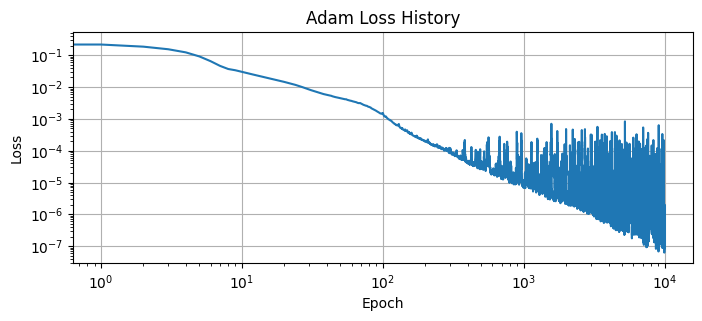

Final loss: 9.80166419140005e-07


In [107]:
idxs = torch.randperm(N_SAMPLES, device=device)[:3]
plt.figure(figsize=(8, 3))
plt.loglog(loss_history)
plt.title('Adam Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

print('Final loss:', loss_history[-1])

Примеры предсказаний нейросетью.

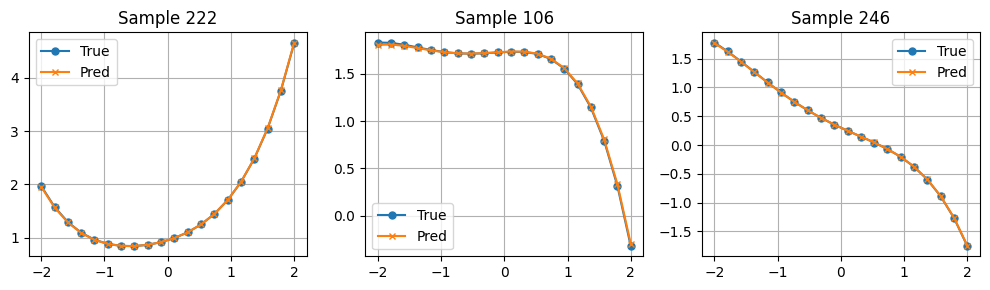

Adam final loss 9.80166419140005e-07


In [106]:
x_np = x.cpu().numpy()
xp = x_powers.detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

for j, ii in enumerate(idxs):
    ax = axs[j]
    true = dataset_coeffs[ii].cpu().numpy() @ xp
    predv = net(dataset_inputs[ii:ii+1]).cpu().detach().numpy().ravel() @ xp
    ax.plot(x_np, true, '-o', label='True', markersize=5)
    ax.plot(x_np, predv, '-x', label='Pred', markersize=5)
    ax.set_title(f'Sample {ii.item()}')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()
print('Adam final loss', loss_history[-1])

## Обучение с использованием RLR

###Описание оптимизатора

Рассмотрим модификацию планировщика, при которой `optimizer` для восстановления параметров остаётся алгоритмом `Adam`, а агент управляет только значением его `learning rate`. Такой подход сохраняет адаптивные моменты, встроенные в `Adam`, но перед каждым шагом меняет масштаб `update` через изменение значения `param_group['lr']`.

Состояние системы двумерное: текущее значение `loss` и локальная разность `loss` между шагами. Награда — это локальное уменьшение `loss` за один шаг оптимизации.

Модель с политикой принимает три значения — уменьшить, оставить, увеличить. Текущее положение на логарифмической сетке `lr` хранится как индекс. Применение действия сводится к сдвигу индекса и его проекции на допустимый диапазон.


Установим `torchrl`.

In [22]:
!pip install -q torchrl

Импорты и подготовка устройства.

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchrl.data import ReplayBuffer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

###Архитектура RLR

Определим архитектуры восстановителя и `Q`-функции. Q-сеть небольшая, поскольку входное пространство состояния низкоразмерно. Реализуем также утилиту для установки `lr` у `optimizer` до вызова `step`.


In [78]:
class DQN(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )
    def forward(self, s):
        return self.net(s)

def set_optimizer_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr

Обучаемая модель.

In [95]:
mac = MaclaurinNet().to(device)
model_opt = torch.optim.Adam(mac.parameters(), lr=1e-3)

Логарифмическая сетка `lr`.

In [96]:
n_lr_grid = 12
lr_values = torch.logspace(-5, -2, steps=n_lr_grid, device=device)

`Policy` и `target` сети.

In [98]:
n_actions_policy = 3
policy = DQN(n_actions_policy).to(device)
target = DQN(n_actions_policy).to(device)
target.load_state_dict(policy.state_dict())

<All keys matched successfully>

Оптимизатор `policy`-сети и `replay`-буфер.

In [99]:
dqn_opt = torch.optim.Adam(policy.parameters(), lr=1e-3)
buffer = ReplayBuffer(batch_size=64)
loss_fn = nn.MSELoss()

###Функции действия и оптимизации

Реализуем вспомогательные функции агента: `$epsilon-greedy` выбор действия и процедуру обучения `DQN` на батче из `replay`-буфера. В оптимизации `DQN` используется `Huber loss` и мягкое обновление весов целевой сети.


In [100]:
def apply_relative_action(idx, action, n_lr):
    shift = torch.tensor(action, dtype=torch.long, device=device) - 1
    idx_new = idx + shift
    idx_new = torch.clamp(idx_new, 0, n_lr - 1)
    return int(idx_new.item())


def select_action(state, step, policy, n_actions, eps_start=0.9, eps_end=0.05, eps_decay=5000):
    eps = eps_end + (eps_start - eps_end) * torch.exp(torch.tensor(-step / eps_decay, device=device))
    if torch.rand(1, device=device).item() > float(eps):
        with torch.no_grad():
            return int(policy(state).argmax(dim=1).item())
    return int(torch.randint(0, n_actions, (1,), device=device).item())


def optimize_model(buffer, policy, target, dqn_opt, batch_size=64, gamma=0.99):
    if len(buffer) < batch_size:
        return

    batch = buffer.sample(batch_size)

    first_s = torch.as_tensor(batch[0][0])
    state_dim = first_s.numel() if first_s.dim() > 0 else 1

    states = torch.zeros((batch_size, state_dim), dtype=torch.float32, device=device)
    next_states = torch.zeros((batch_size, state_dim), dtype=torch.float32, device=device)
    actions = torch.zeros(batch_size, dtype=torch.long, device=device)
    rewards = torch.zeros(batch_size, dtype=torch.float32, device=device)

    for i, b in enumerate(batch):
        s = torch.as_tensor(b[0]).float().flatten()
        ns = torch.as_tensor(b[2]).float().flatten()
        if s.numel() != state_dim:
            s = s.repeat(state_dim)[:state_dim]
        if ns.numel() != state_dim:
            ns = ns.repeat(state_dim)[:state_dim]
        states[i] = s.to(device)
        next_states[i] = ns.to(device)
        a_tensor = torch.as_tensor(b[1])
        actions[i] = int(a_tensor.view(-1)[0].item())
        r_tensor = torch.as_tensor(b[3])
        rewards[i] = float(r_tensor.view(-1)[0].item())

    q_vals = policy(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        q_next = target(next_states).max(1).values
    targets = rewards + gamma * q_next

    loss_q = nn.SmoothL1Loss()(q_vals, targets)
    dqn_opt.zero_grad()
    loss_q.backward()
    dqn_opt.step()

    for tp, pp in zip(target.parameters(), policy.parameters()):
        tp.data.copy_(0.995 * tp.data + 0.005 * pp.data)


### Цикл обучения планировщика

Начальный индекс `lr` ставится в середину сетки. На каждом шаге вычисляется градиент по всему датасету, агент выбирает относительное действие, индекс `lr` обновляется с учётом проекции на границы, оптимизатор `Adam` получает новое `param_group['lr']` и выполняет шаг. Переходы записываются в каноническом формате.

Награда вычисляется как уменьшение `loss` за шаг и добавляется переход в буфер, после чего производится обновление `DQN`.


In [101]:
def train_scheduler_relative(mac, model_opt, policy, target, dqn_opt, buffer, inputs, targets, lr_values, steps=1200):
    loss_prev = loss_fn(mac(inputs), targets).item()
    lr_traj, loss_traj = [], [loss_prev]
    lr_idx = n_lr_grid // 2

    for t in range(steps):
        preds = mac(inputs)
        loss = loss_fn(preds, targets)
        state = torch.tensor([loss.item(), loss.item() - loss_prev], device=device).float().unsqueeze(0)

        action = select_action(state, t, policy, n_actions_policy)
        lr_idx = apply_relative_action(lr_idx, action, n_lr_grid)
        lr = float(lr_values[lr_idx].item())
        model_opt.zero_grad()
        loss.backward()

        set_optimizer_lr(model_opt, lr)
        model_opt.step()

        loss_new = loss_fn(mac(inputs), targets).item()
        next_state = torch.tensor([loss_new, loss_new - loss.item()], device=device).float().reshape(-1)

        reward = loss.item() - loss_new
        buffer.add((state.reshape(-1).cpu(), torch.tensor(action), next_state.cpu(), torch.tensor(reward)))

        optimize_model(buffer, policy, target, dqn_opt)
        lr_traj.append(lr)
        loss_traj.append(loss_new)
        loss_prev = loss_new

    return loss_traj, lr_traj


Обучим модели.

In [ ]:
loss_traj, lr_traj = train_scheduler_relative(mac, model_opt, policy, target, dqn_opt, buffer, dataset_inputs, dataset_coeffs, lr_values, steps=10000)

###Анализ результатов

Визуализация показывает динамику `loss` и последовательность выбранных `learning rate`. На графиках можно оценить, как агент сочетает агрессивные и консервативные шаги в зависимости от текущего поведения ошибки.


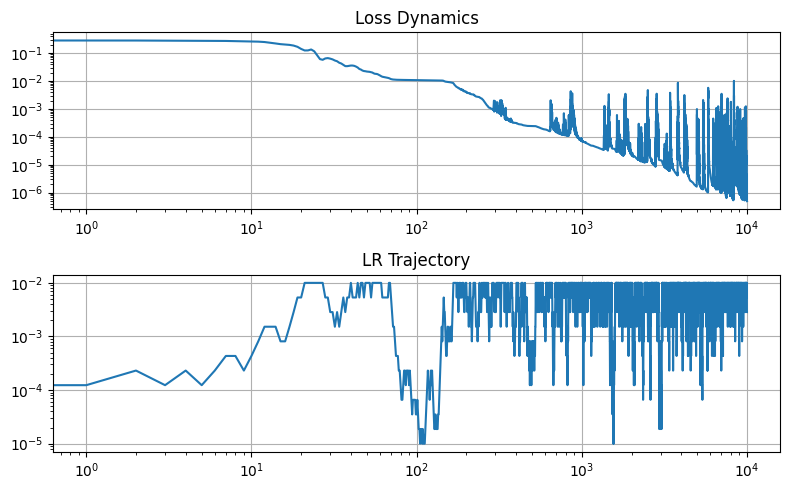

Final loss: 4.960174351253954e-07


In [111]:
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.loglog(loss_traj)
plt.grid()
plt.title('Loss Dynamics')

plt.subplot(2, 1, 2)
plt.loglog(lr_traj)
plt.grid()
plt.title('LR Trajectory')

plt.tight_layout()
plt.show()

print('Final loss:', loss_traj[-1])


График `lr` показывает, что агент первые $60$ эпох повышал его для ускорения сходимости, так как инициализированного значения $lr$ не хватало для уменьшения $loss$, а затем к $100$-й итерации понижал до минимума для более тонкой настройки.

Однако, как видно из графика потерь, это не привело к улучшению, вследствие чего агент повысил `lr` до максимально доступного значения примерно к $110$-й итерации. Затем оба графика активно осциллируют, хотя и наблюдается общее снижение $loss$. Из графика $lr$ видно, что агент находит оптимальными значения $lr$ в диапазоне выше $10^{-4}$.

### Сравнение RLR-решения и baseline

Использование планировщика `Reinforcement-learning-based Learning Rate Scheduler` (`RLR Scheduler`) за то же число итераций ($10000$) привело к **вдвое более точному результату**, чем обучение с эвристически подобранным гиперпараметром $lr=10^{-3}$.

Более того, кривая `loss` для обучения без агента имеет куда более пологий характер, угол её наклона в двойном логарифмическом масштабе значительно меньше. С увеличением числа эпох `loss` значительно реже осциллирует при использовании `RLR` относительно эвристики, хотя скачки в среднем выше.  

Это указывай на высокий потенциал агентов в решении задач динамического подбора гиперпараметров, в частности темпа обучения.